In [ ]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rdkit import Chem
from model.gnn import MolGNN, MolGNNConfig
from train.dataset import MoleculeDataset
import pandas as pd
import numpy as np
from model.utils import smiles_to_graph
import torch
from tqdm import tqdm
from rdkit.Chem import Crippen, AllChem
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import joblib
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('data/test_data.csv')  # Load your dataset
#data = data[:1000]
data.columns = data.columns.str.lower()  # Normalize column names to lowercase
# Calculate logP using RDKit for each SMILES
def calc_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return Crippen.MolLogP(mol)

y_test = data['logp'].values
data.head()


,filename,homo,lumo,smiles,sas,logp,tpsa,scaffold
0,a10012,-5.706231,-2.751073,CC(=O)c1csc2c1C(=O)c1c(-c3cc(-c4ccsc4)ccc3[N+]...,3.139781,6.5273,77.28,O=C1c2ccsc2-c2scc(-c3cccc(-c4ccsc4)c3)c21
1,a10013,-5.725279,-2.723861,CC(=O)c1sc2c(c1-c1cc(-c3ccsc3)ccc1[N+](=O)[O-]...,3.075941,6.5273,77.28,O=C1c2ccsc2-c2scc(-c3cccc(-c4ccsc4)c3)c21
2,a10026,-5.409626,-2.405488,COC(=O)c1cscc1-c1ccc([N+](=O)[O-])c(-c2csc3c2C...,3.172331,6.1113,86.51,O=C1c2ccsc2-c2scc(-c3cccc(-c4ccsc4)c3)c21
3,a10029,-5.883105,-2.873524,O=C1c2cc(C(F)(F)F)sc2-c2scc(-c3cc(-c4ccsc4)ccc...,3.210529,7.3435,60.21,O=C1c2ccsc2-c2scc(-c3cccc(-c4ccsc4)c3)c21
4,a10036,-5.621875,-2.625900,O=C1c2ccsc2-c2scc(-c3cc(-c4csc(C(F)(F)F)c4)ccc...,3.235717,7.3435,60.21,O=C1c2ccsc2-c2scc(-c3cccc(-c4ccsc4)c3)c21


In [17]:
#train_dataset = MoleculeDataset(data['smiles'], data['logp'], num_atoms=None, atom_dim=None, bond_dim=None, atom_stoi=None, bond_stoi=None)

In [25]:
# --- 1. Setup Model and Dictionaries ---
# Ensure these configurations match your trained model
config = MolGNNConfig(input_dim=12, hidden_dim=128, output_dim=1, num_layers=5, bond_dim=4)
atom_stoi = {'B': 0,'Br': 1,'C': 2,'Cl': 3,'F': 4,'H': 5,'N': 6,'O': 7,'P': 8,'S': 9,'Se': 10,'Si': 11}
bond_stoi = {'AROMATIC': 0, 'DOUBLE': 1, 'SINGLE': 2, 'TRIPLE': 3}
MAX_ATOMS = 72 # This MUST match the num_atoms used during training

# Load the trained model
model = MolGNN(config.input_dim, config.hidden_dim, config.output_dim, config.num_layers, config.bond_dim)
model.load_state_dict(torch.load('model_checkpoint.pth', map_location='cpu'))
model.eval()

# --- 2. Filter SMILES by Atom Count ---
# Define a function to count atoms
def count_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms() if mol else 0

# Add atom count to the dataframe and filter
# Make sure the 'data' DataFrame is loaded from a previous cell
data['num_atoms'] = data['smiles'].apply(count_atoms)
filtered_data = data[data['num_atoms'] <= MAX_ATOMS].copy()
smiles_to_predict = filtered_data['smiles'].tolist()
y_true_filtered = filtered_data['logp'].values # Get ground truth for the filtered data

print(f"Found {len(smiles_to_predict)} molecules with {MAX_ATOMS} or fewer atoms (out of {len(data)} total).")

# --- 3. Loop and Predict ---
predictions = []
with torch.no_grad():
    for smiles in tqdm(smiles_to_predict, desc="Predicting SMILES"):
        # Convert SMILES to graph representation
        x_fea, x_adj = smiles_to_graph(
            smiles,
            atom_stoi,
            bond_stoi,
            num_atoms=MAX_ATOMS,
            atom_dim=config.input_dim,
            bond_dim=config.bond_dim
        )
        
        # Convert to tensors and add batch dimension
        x_fea_tensor = torch.from_numpy(x_fea).float().unsqueeze(0)
        x_adj_tensor = torch.from_numpy(x_adj).float().unsqueeze(0)
        
        # Get prediction
        prediction = model(x_fea_tensor, x_adj_tensor)
        predictions.append(prediction.item())



Found 12635 molecules with 72 or fewer atoms (out of 12635 total).


Predicting SMILES: 100%|██████████| 12635/12635 [00:16<00:00, 789.00it/s]


In [ ]:
# Compute Morgan fingerprint from SMILES
def compute_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [0] * n_bits
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
    return list(fp)

smiles_list = data['smiles']
fp = [compute_fingerprint(smiles) for smiles in smiles_list]
rf = joblib.load('rf_model.pkl')  # Load the trained Random Forest model
mlp = joblib.load('mlp_model.pkl')  # Load the trained MLP model
gb_model = joblib.load('gb_model.pkl')  # Load the trained Gradient Boosting model
mlp_y_pred = mlp.predict(fp)  # Predict using MLP
gb_y_pred = gb_model.predict(fp)  # Predict using Gradient Boosting
y_pred = rf.predict(fp)

In [34]:
# Compute Morgan fingerprint from SMILES
def compute_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [0] * n_bits
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
    return list(fp)

smiles_list = data['smiles']
fp = [compute_fingerprint(smiles) for smiles in smiles_list]
rf = joblib.load('rf_model.pkl')  # Load the trained Random Forest model
mlp = joblib.load('mlp_model.pkl')  # Load the trained MLP model
gb = joblib.load('gb_model.pkl')  # Load the trained Gradient Boosting model
mlp_y_pred = mlp.predict(fp)  # Predict using MLP
gb_y_pred = gb.predict(fp)
rf_y_pred = rf.predict(fp)

[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerator
[14:37:12] DEPRECATION WARNING: please use MorganGenerat

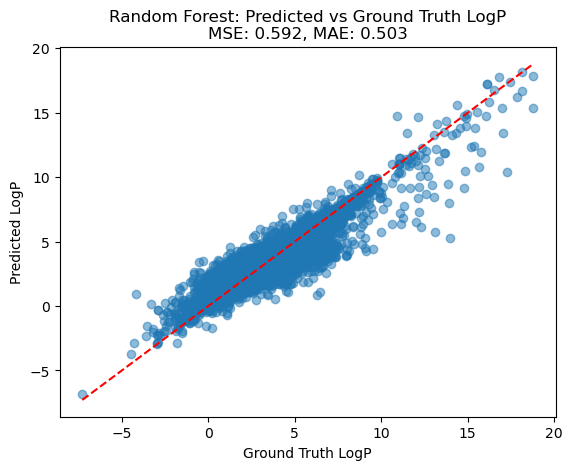

MAE: 0.5034830171419341, RMSE: 0.5921601857998419


In [35]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Ground Truth LogP')
plt.ylabel('Predicted LogP')
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
plt.title(f'Random Forest: Predicted vs Ground Truth LogP\nMSE: {mse:.3f}, MAE: {mae:.3f}')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
print(f'MAE: {mae}, RMSE: {mse}')

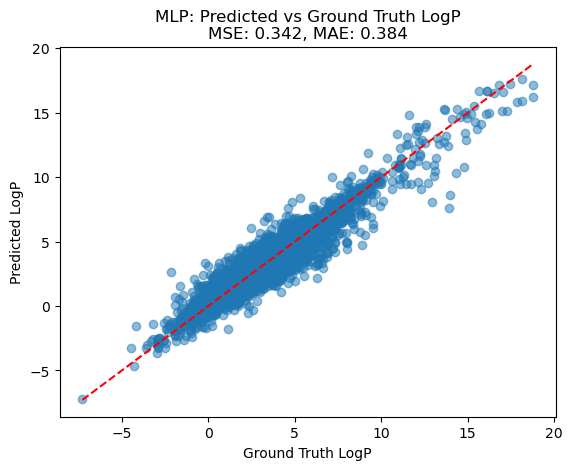

MAE: 0.38358702023864594, RMSE: 0.3417765472626707


In [36]:
plt.scatter(y_test, mlp_y_pred, alpha=0.5)
plt.xlabel('Ground Truth LogP')
plt.ylabel('Predicted LogP')
mse = mean_squared_error(y_test, mlp_y_pred)
mae = mean_absolute_error(y_test, mlp_y_pred)
plt.title(f'MLP: Predicted vs Ground Truth LogP\nMSE: {mse:.3f}, MAE: {mae:.3f}')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
print(f'MAE: {mae}, RMSE: {mse}')

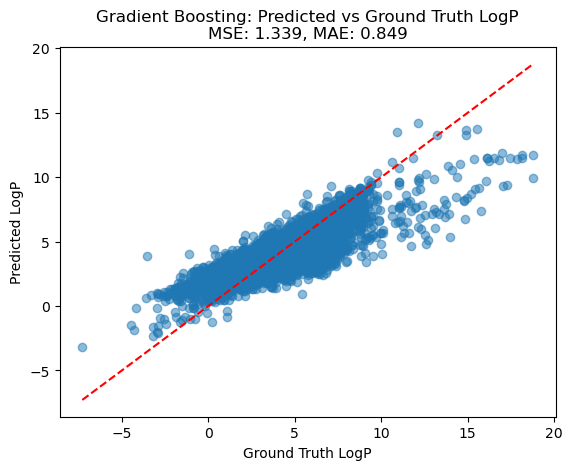

MAE: 0.848876972478681, RMSE: 1.339049695055171


In [38]:
# Gradient Boosting Evaluation
plt.scatter(filtered_data['logp'].values, gb_y_pred, alpha=0.5)
plt.xlabel('Ground Truth LogP')
plt.ylabel('Predicted LogP')
mse_gb = mean_squared_error(filtered_data['logp'].values, gb_y_pred)
mae_gb = mean_absolute_error(filtered_data['logp'].values, gb_y_pred)
plt.title(f'Gradient Boosting: Predicted vs Ground Truth LogP\nMSE: {mse_gb:.3f}, MAE: {mae_gb:.3f}')
plt.plot([filtered_data['logp'].min(), filtered_data['logp'].max()],
         [filtered_data['logp'].min(), filtered_data['logp'].max()], 'r--')
plt.show()
print(f'MAE: {mae_gb}, RMSE: {mse_gb}')

In [ ]:
# MolGNN

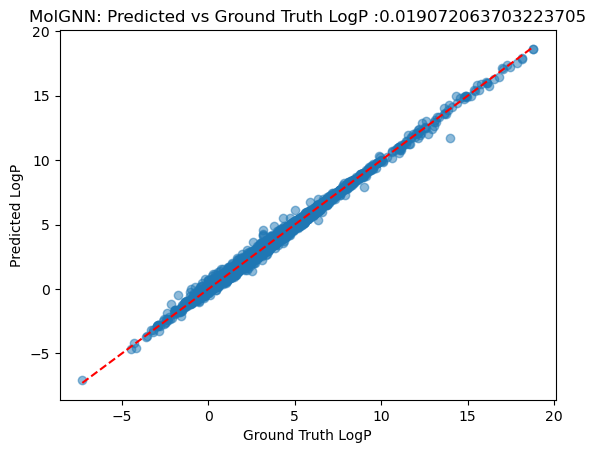

MAE: 0.0943524007734714, RMSE: 0.019072063703223705


In [26]:

y_true_gnn = y_true_filtered # Use the filtered ground truth
y_pred_gnn = predictions

plt.scatter(y_true_gnn, y_pred_gnn, alpha=0.5)
plt.xlabel('Ground Truth LogP')
plt.ylabel('Predicted LogP')
plt.title(f'MolGNN: Predicted vs Ground Truth LogP :{mean_squared_error(y_true_gnn, y_pred_gnn)}')
plt.plot([min(y_true_gnn.min(), min(y_pred_gnn)), max(y_true_gnn.max(), max(y_pred_gnn))],
         [min(y_true_gnn.min(), min(y_pred_gnn)), max(y_true_gnn.max(), max(y_pred_gnn))], 'r--')
plt.show()
print(f'MAE: {mean_absolute_error(y_true_gnn, y_pred_gnn)}, RMSE: {mean_squared_error(y_true_gnn, y_pred_gnn)}')